In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Audio,Image
from PIL import Image as PIL_Image
import multiprocessing
from joblib import Parallel,delayed
import gc, pickle

import os,sys
os.system("taskset -p 0xff %d" % os.getpid())
sys.path.append(os.path.expanduser('~')+'/audio_class/python')
sys.path.append('../../audio_class/python')
import audio_class
import ridgeDTW
import delay2loc
import audio_loc

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATAROOT = './BBSPjun5_13/'

In [3]:
# load mics' locations
micsloc = []
with open('micloc1.csv','r') as fid:
    for lines in fid:
        tokens = lines.split(',')
        micsloc.append([float(tokens[0]),float(tokens[1]),float(tokens[2])])
micsloc = np.array(micsloc)
print('micsloc = %s' % micsloc)

micsloc = [[-39.624   -3.048    3.048 ]
 [-30.48     0.       3.048 ]
 [-21.336    0.       0.9144]
 [-12.192   -3.048    0.9144]
 [ -3.048   -3.048    3.048 ]
 [  6.096    0.       3.048 ]
 [ 15.24    -3.048    0.9144]
 [ 24.384    0.       0.9144]]


In [4]:
########## Work on a single recording first
fs,data = audio_class.readSegment(DATAROOT+'day2-1370485107.wav')
NCh,NDat = np.shape(data)

In [5]:
print('fs = %s' % fs)
print('NCh = %s, NDat = %s' % (NCh,NDat))
#Audio(data[0,:],rate=fs)

fs = 44100
NCh = 8, NDat = 2646000


In [21]:
# hierarchical processing
tHieBlk=[0.032,0.256]
tHieInc=[0.004,0.032]
hRidges,hSpecs = audio_loc.hieProc(data,fs,tHieBlk,tHieInc)

In [6]:
#with open('./hRidges_hSpecs.pkl','wb') as fid:
#    pickle.dump((hRidges,hSpecs),fid)
#with open('./hRidges_hSpecs.pkl','rb') as fid:
#    hRidges,hSpecs = pickle.load(fid)

True
n1 = 0, n2 = 1879


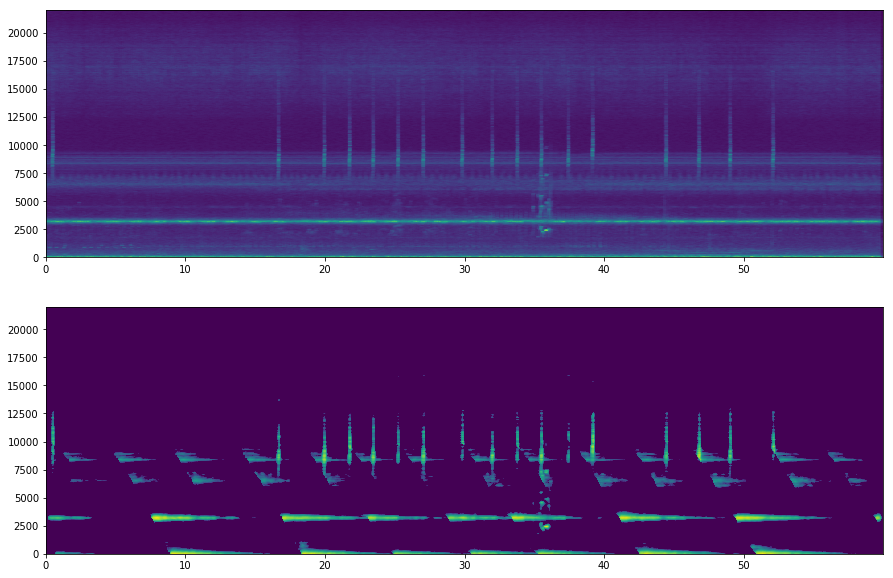

In [7]:
level = 1
chIdx = 7
S,F,T,tBlk,tInc = hSpecs[level][chIdx]
X = hRidges[level][chIdx]
print(tInc == T[1]-T[0])
n1 = int(0/tInc)
n2 = int(60/tInc)
print('n1 = %s, n2 = %s' % (n1,n2))

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.pcolormesh(T[n1:n2],F,np.sqrt(S[:,n1:n2]))
plt.subplot(212)
plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

In [7]:
# per-channel cross-level processing
gc.collect()

tSegBlk = 2.
tSegInc = 1.
def xLevelProc(k,hRidges,hSpecs,tSegBlk,tSegInc):
    # per channel inputs
    Xh = hRidges[1][k]
    _,_,_,_,thInc = hSpecs[1][k]
    Xl = hRidges[0][k]
    _,_,_,_,tlInc = hSpecs[0][k]
    #print(thInc/tlInc)
    
    # Segmenting for causal/online processing 
    # and reduce computational load
    XhSegs,tSegBlk,tSegInc = audio_loc.segment(Xh,tSegBlk,tSegInc,thInc)
    #print('np.shape(XhSegs) = %s' % (np.shape(XhSegs),))
    lObjsAll = [None]*len(XhSegs)
    for l in range(30,40):#len(XhSegs)):
        # extract high-level objects
        hObjs = audio_loc.labelObjects(XhSegs[l])
        hObjs = audio_loc.pruneObj(hObjs)
        #print('np.shape(hObjs) = %s' % (np.shape(hObjs),))
        
        # extract low-level objects given high-level ones as masks
        n0,n1 = audio_loc.seg2bounds(l,tSegBlk,tSegInc,tlInc)
        XX = Xl[:,n0:n1]
        
        # debugging plots
        '''
        plt.figure()
        plt.subplot(211)
        plt.pcolormesh(XhSegs[l])
        plt.ylabel('XhSegs[l]')
        plt.subplot(212)
        plt.pcolormesh(XX)
        plt.ylabel('XX')
        '''
        
        lObjsGrp = [None]*len(hObjs)
        for i in range(len(hObjs)):
            # temporal upsampling with 
            # thInc: higher level time increment/scale
            # tlInc: lower level time increment/scale
            mask = np.repeat(hObjs[i],int(thInc/tlInc),axis=1)
            mask[mask > 0] = 1.
            '''
            print(np.shape(XX))
            print(np.shape(mask))
            plt.figure()
            plt.pcolormesh(mask)
            plt.ylabel('mask')
            '''
            lObjs = audio_loc.labelObjects(mask*np.pad(XX,((0,0),(0,mask.shape[1]-XX.shape[1])),'constant'))
            lObjs = audio_loc.pruneObj(lObjs)
            
            # all low-level objects belong to the same group
            lObjsGrp[i] = lObjs
        print('np.shape(lObjsGrp) = %s' % (np.shape(lObjsGrp),))
        '''
        plt.figure()
        plt.pcolormesh(lObjsGrp[0][0])
        '''
        
        lObjsAll[l] = lObjsGrp
        
    return lObjsAll
        
lObjsAllCh = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(xLevelProc)\
            (k,hRidges,hSpecs,tSegBlk,tSegInc) for k in range(NCh))
# swap channel and temporal segment index 
# to streamline subsequent multichannel processing
lObjsAllCh = np.swapaxes(lObjsAllCh,0,1)

print('np.shape(lObjsAllCh) = %s' % (np.shape(lObjsAllCh),))

np.shape(lObjsGrp) = (1, 4, 512, 682)
np.shape(lObjsGrp) = (1, 9, 512, 682)
np.shape(lObjsGrp) = (1, 2, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (1, 10, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (1, 3, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (3,)
np.shape(lObjsGrp) = (1, 2, 512, 682)
np.shape(lObjsGrp) = (1, 8, 512, 682)
np.shape(lObjsGrp) = (1, 11, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (1, 9, 512, 682)
np.shape(lObjsGrp) = (1, 10, 512, 682)
np.shape(lObjsGrp) = (1, 7, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (1, 1, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (1, 4, 512, 682)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (2,)
np.shape(lObjsGrp) = (1, 1, 512, 682)
np.shape(lObjsGrp) = (1, 5, 512, 682)
np.shape(lO

In [7]:
#with open('./lObjsAllCh.pkl','wb') as fid:
#    pickle.dump(lObjsAllCh,fid)
#with open('./lObjsAllCh.pkl','rb') as fid:
#    lObjsAllCh = pickle.load(fid)

(61, 8)
(3,)
(6, 512, 682)


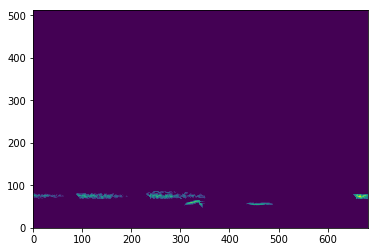

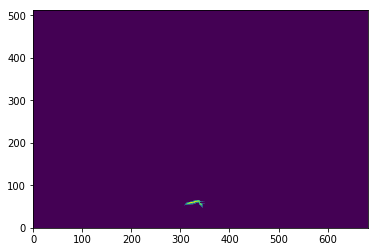

In [8]:
segIdx = 35 # audio segment/clip index
chIdx = 7 # channel index
grpIdx = 1 # group (of objects) index
objIdx = 0 # object index
print(np.shape(lObjsAllCh))
print(np.shape(lObjsAllCh[segIdx][chIdx])) # num of groups
print(np.shape(lObjsAllCh[segIdx][chIdx][grpIdx])) # num of objects

plt.figure()
plt.pcolormesh(np.mean(lObjsAllCh[segIdx][chIdx][grpIdx],axis=0))
plt.figure()
plt.pcolormesh(lObjsAllCh[segIdx][chIdx][grpIdx][objIdx])

In [9]:
# generates 3D images of our environment
# refs: TRTimage.py from mpop
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h, 4 ) # quick reshape
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
# refs: http://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
def draw_ball(axes,cen,rad):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = rad[0]*np.cos(u)*np.sin(v)
    y = rad[1]*np.sin(u)*np.sin(v)
    z = rad[2]*np.cos(v)
    axes.plot_wireframe(cen[0]+x,cen[1]+y,cen[2]+z,color="r")

In [27]:
# forming and working with groups
grps = np.zeros(np.shape(lObjsAllCh),dtype=object)
for segIdx in range(30,40):
    for chIdx in range(NCh):
        grps[segIdx,chIdx] = [None]*len(lObjsAllCh[segIdx,chIdx])
        for grpIdx in range(len(lObjsAllCh[segIdx,chIdx])):
            grps[segIdx,chIdx][grpIdx] = np.mean(lObjsAllCh[segIdx,chIdx][grpIdx],axis=0)
    
# find the most overlapped set of groups
#print(np.shape(grps[30]))
seq = audio_loc.bestLink(grps[30])
#print(seq)
if len(seq) == 0:
    print('empty seq')

[1, 0, 0, 0, 0, 0, 1, 1]
[]
[1, 0, 0, 0, 0, 0, 0, 0]
[]
[0, 0, 1, 1, 0, 0, 0, 0]
[]
[0, 1, 0, 0, 1, 0, 0, 0]
[]
[0, 1, 0, 0, 0, 0, 1, 1]
[]
[0, 0, 0, 0, 0, 0, 1, 1]
[]
[0, 0, 1, 1, 0, 0, 1, 2]
[]
[0, 0, 1, 0, 0, 0, 1, 1]
[]
[0, 0, 1, 0, 0, 0, 0, 0]
[]
[0, 0, 0, 0, 0, 0, 0, 0]
[]


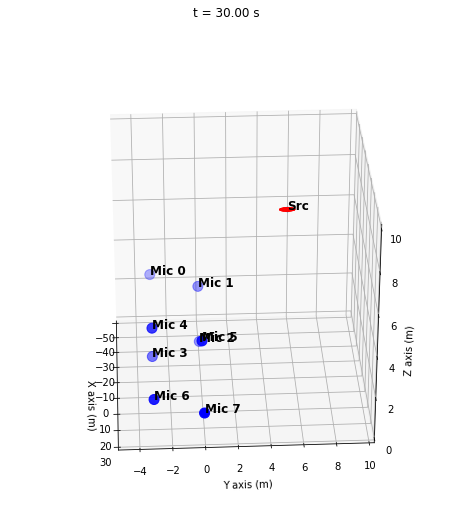

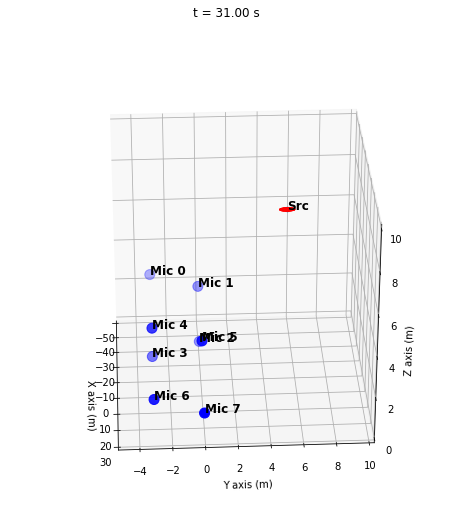

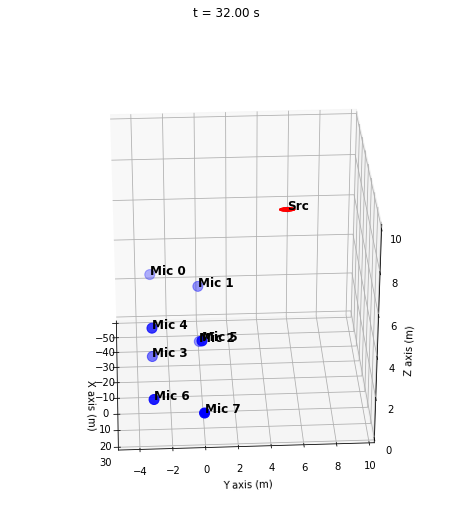

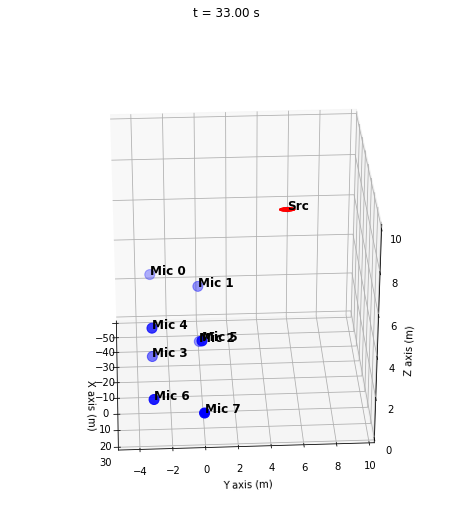

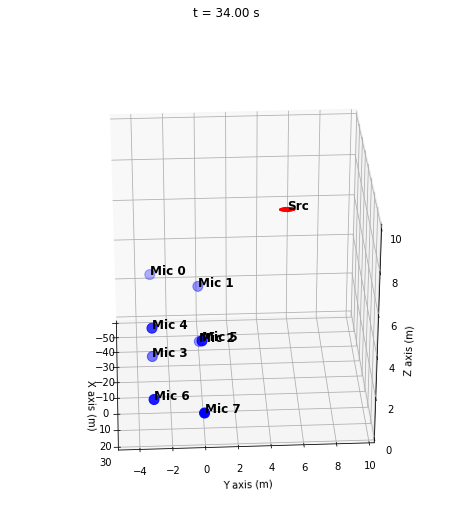

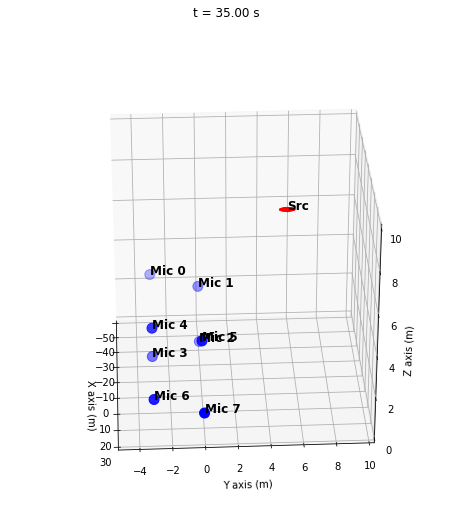

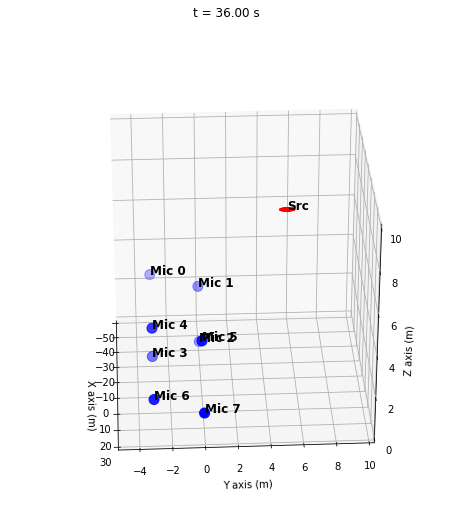

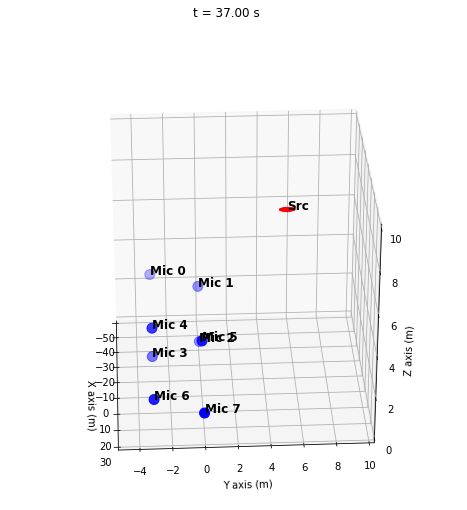

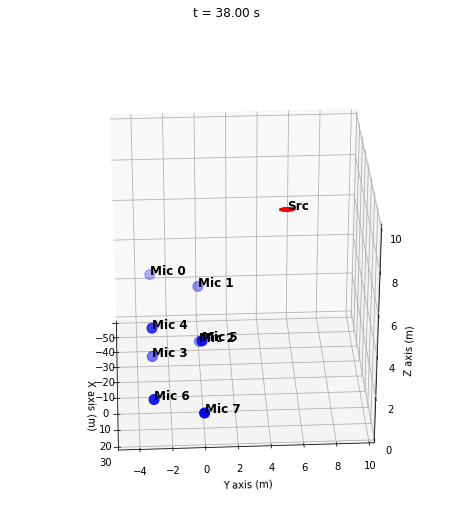

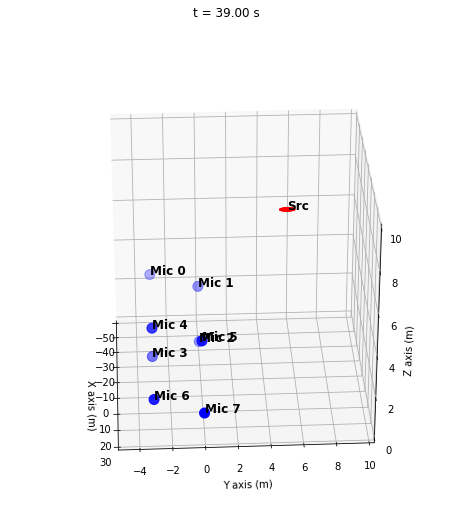

In [28]:
_,_,_,_,tInc = hSpecs[0][0]
images = []
durations = [] # ms
for segIdx in range(30,40):
    # draw pic frame
    fig = plt.figure(figsize=(8,8))
    axes = fig.gca(projection='3d')
    #axes.set_aspect("equal")
    
    while True:
        # generate output for each channel
        seq = audio_loc.bestLink(grps[segIdx])
        print(seq)
        if len(seq) == 0:
            break
        out = [None]*NCh
        for chIdx in range(NCh):
            # get the chosen group and avg over freq
            out[chIdx] = np.mean(grps[segIdx,chIdx][seq[chIdx]],axis=0)

        # remove the connected groups
        audio_loc.rmGrp(grps[segIdx],seq)
        '''
        plt.figure()
        for chIdx in range(NCh):
            plt.plot(out[chIdx])
        '''

        # form the measurement matrix, i.e.
        # measure the delays in matrix form
        meas_delayMat = np.zeros((NCh,NCh))
        for k in range(NCh):
            for l in range(k+1,NCh):
                corr = sp.signal.correlate(out[k],out[l])
                '''
                print(np.argmax(corr))
                plt.figure()
                plt.plot(corr)
                '''
                meas_delayMat[k,l] = meas_delayMat[l,k] = \
                    tInc*(np.argmax(corr)-len(corr)//2)
        #print(meas_delayMat)

        # localize the source from the given delay measurement 
        loc,err,grad = delay2loc.delay2loc_grad(micsloc,meas_delayMat)
        
        axes.scatter(loc[0],loc[1],loc[2])
        axes.text(loc[0],loc[1],loc[2],'Src',fontweight='bold',fontsize='large')
        draw_ball(axes,loc,grad/max(grad))

    axes.scatter(micsloc[:,0],micsloc[:,1],micsloc[:,2],s=100,c='b')
    for k in range(NCh):
        axes.text(micsloc[k,0],micsloc[k,1],micsloc[k,2],'Mic %s' % k,
                  fontweight='bold',fontsize='large')

    axes.set_xlabel('X axis (m)')
    axes.set_xlim([-50,30])
    axes.set_ylabel('Y axis (m)')
    axes.set_ylim([-5,10])
    axes.set_zlabel('Z axis (m)')
    axes.set_zlim([0,10])
    
    fig.suptitle('t = %.2f s' % (segIdx*tSegInc))

    # draw with rotating azimuth angle
    for angle in range(0,360,3):
        axes.view_init(30, angle)
        imData = fig2data(fig)
        w,h,d = imData.shape
        im = PIL_Image.frombytes('RGBA',(w,h),imData)
        images.append(im)
        durations.append(100)

(576, 576)
True
<PIL.Image.Image image mode=RGBA size=576x576 at 0x7F8480C8D4A8>


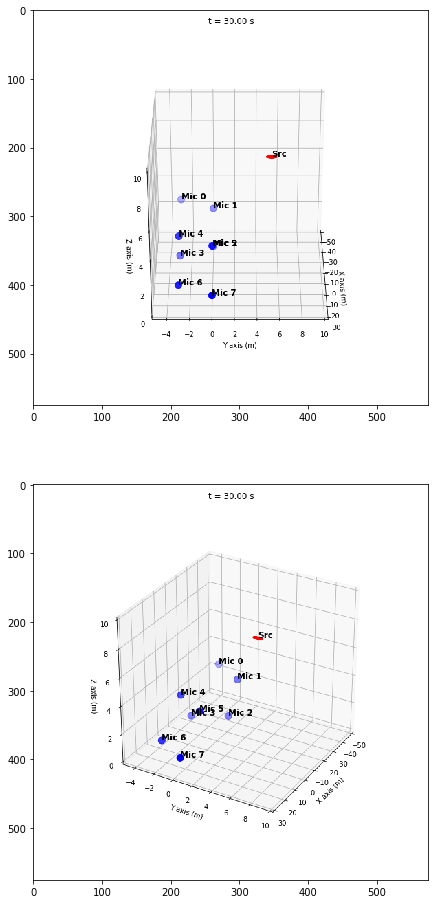

In [29]:
# sanity checks
size = fig.get_size_inches()*fig.dpi # size in pixels
size = tuple(size.astype(int))
print(size)
#print('(%s, %s)' % (w,h))
print(size == (w,h))

print(images[0])
plt.figure(figsize=(8,16))
plt.subplot(211)
plt.imshow(images[0])
plt.subplot(212)
plt.imshow(images[10])

In [30]:
# Animate
gif_pathname = 'images/micsloc_srcloc.gif'
gif = images[0]
#gif.info['duration'] = tuple([100]*len(images)) # ms per frame
gif.info['duration'] = tuple(durations)
gif.info['loop'] = 0 # how many times to loop (0=infinite)
gif.save(fp=gif_pathname, format='gif', save_all=True, append_images=images[1:])

# verify that the number of frames in the gif equals the number of image files and durations
print(len(images))
print(PIL_Image.open(gif_pathname).n_frames == len(images))

# might need to refresh the page to reload the image,
# according to https://github.com/jupyter/notebook/issues/1369
Image(url=gif_pathname)

1200
True


In [ ]:
########## Work on all recordings
for file in os.listdir(DATAROOT):
    print(file)
    fs,data = audio_class.readSegment(DATAROOT+file)
    break